# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
df = df.sort_index()

df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [3]:
def create_features(data):
    data = data.copy()
    
    data['lag_1'] = data['num_orders'].shift(1)
    data['lag_24'] = data['num_orders'].shift(24)
    data['lag_48'] = data['num_orders'].shift(48)
    
    data['roll_3'] = data['num_orders'].shift(1).rolling(window = 3).mean()
    data['roll_24'] = data['num_orders'].shift(1).rolling(window = 24).mean()
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data['dayofweek'].isin([5,6]).astype(int)
    
    return data

In [4]:
df = create_features(df).dropna()
df

,num_orders,lag_1,lag_24,lag_48,roll_3,roll_24,hour,dayofweek,is_weekend
datetime,,,,,,,,,
2018-03-03 00:00:00,163,72.0,90.0,124.0,97.333333,62.750000,0,5,1
2018-03-03 01:00:00,108,163.0,120.0,85.0,118.000000,65.791667,1,5,1
2018-03-03 02:00:00,25,108.0,75.0,71.0,114.333333,65.291667,2,5,1
2018-03-03 03:00:00,64,25.0,64.0,66.0,98.666667,63.208333,3,5,1
2018-03-03 04:00:00,44,64.0,20.0,43.0,65.666667,63.208333,4,5,1
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.0,72.0,169.0,207.000000,164.875000,19,4,0
2018-08-31 20:00:00,154,136.0,142.0,191.0,186.666667,167.541667,20,4,0
2018-08-31 21:00:00,159,154.0,198.0,170.0,165.666667,168.041667,21,4,0


In [5]:
features = df.drop(['num_orders'], axis = 1)
target = df['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.20, shuffle=False)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size = 0.50, shuffle = False)

print("Train:", features_train.shape, target_train.shape)
print("Valid:", features_valid.shape, target_valid.shape)
print("Test:", features_test.shape, target_test.shape)

Train: (3494, 8) (3494,)
Valid: (437, 8) (437,)
Test: (437, 8) (437,)


## Analysis

<div class="alert alert-info"; style="border-left: 7px solid blue">
<b>Student’s Comment</b>
<br>Added in the timeseries graphs

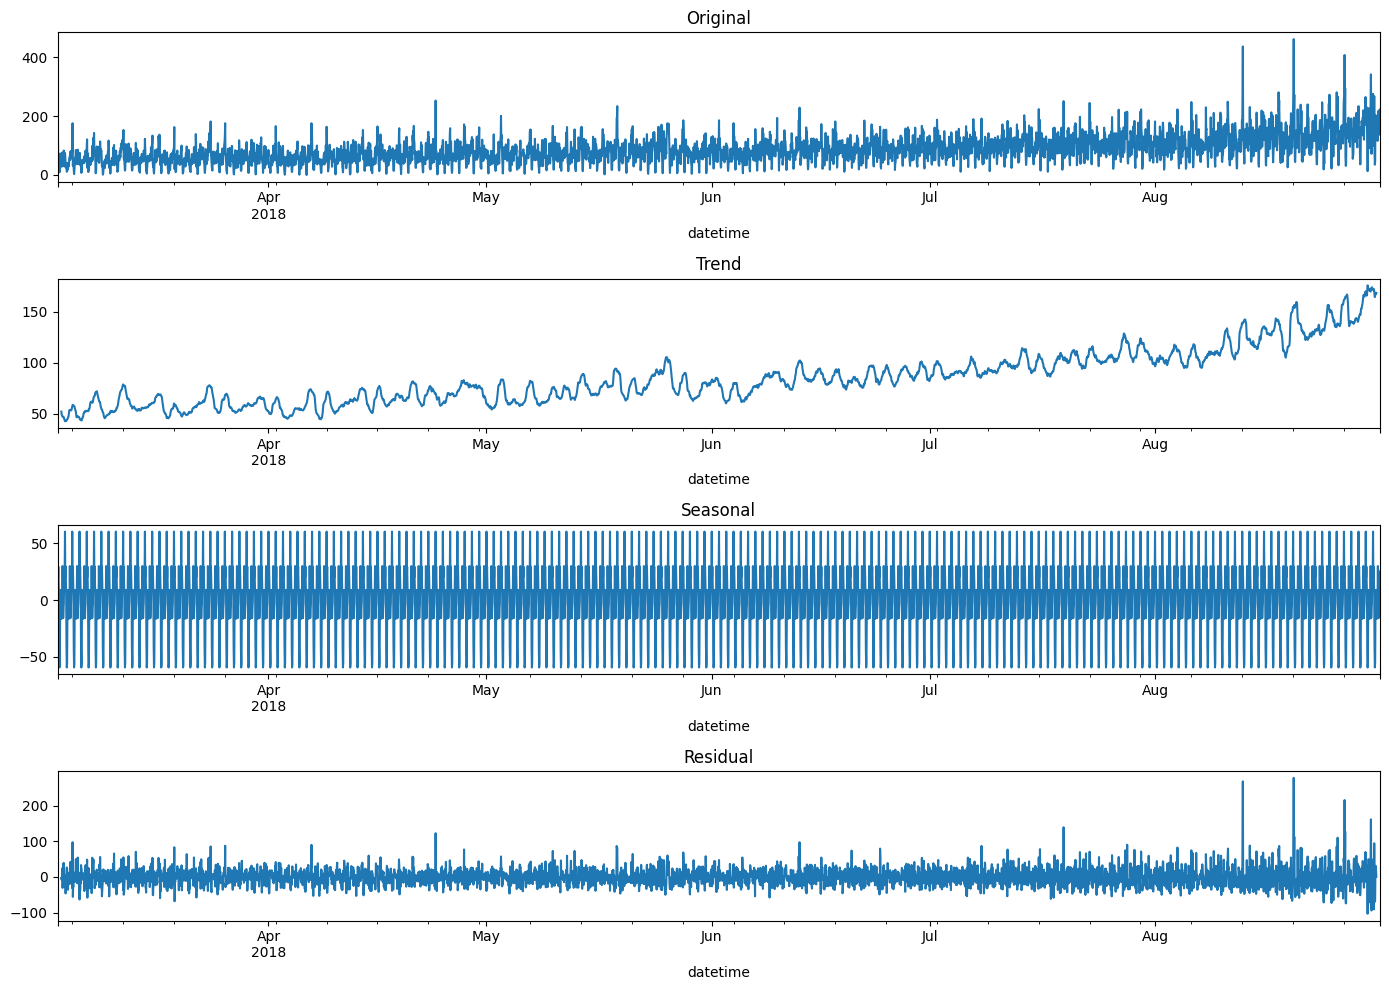

In [6]:
decomp = seasonal_decompose(df['num_orders'], model='additive', period = 24)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomp.observed.plot(ax=axes[0], title='Original')
decomp.trend.plot(ax=axes[1], title='Trend')
decomp.seasonal.plot(ax=axes[2], title='Seasonal')
decomp.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

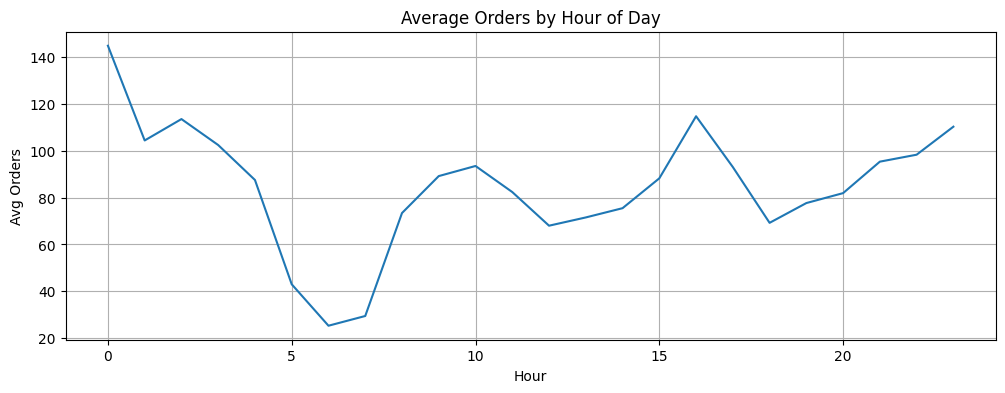

In [7]:
plt.figure(figsize=(12,4))
df.groupby(df.index.hour)['num_orders'].mean().plot()
plt.title("Average Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg Orders")
plt.grid(True)
plt.show()

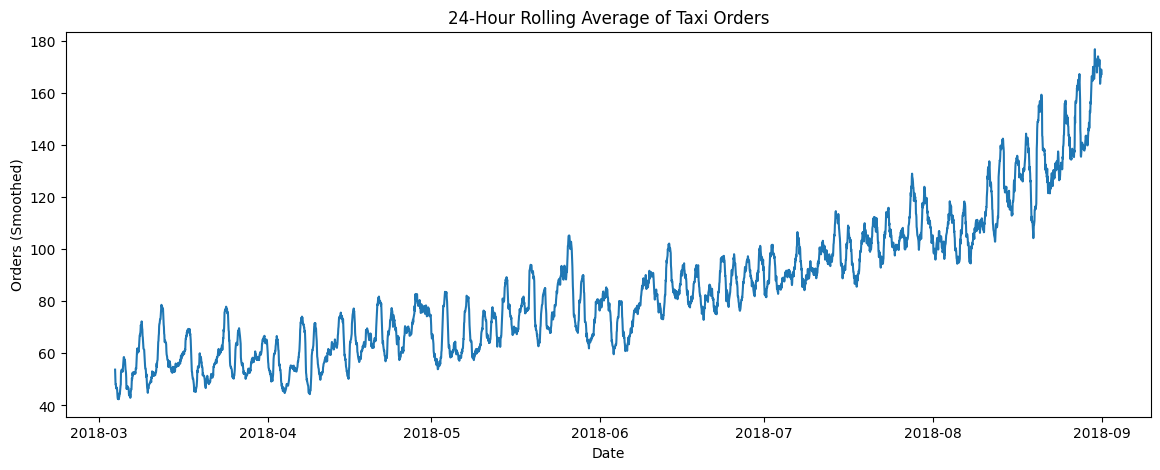

In [8]:
plt.figure(figsize=(14,5))
plt.plot(df['num_orders'].rolling(24).mean())
plt.title('24-Hour Rolling Average of Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Orders (Smoothed)')
plt.show()

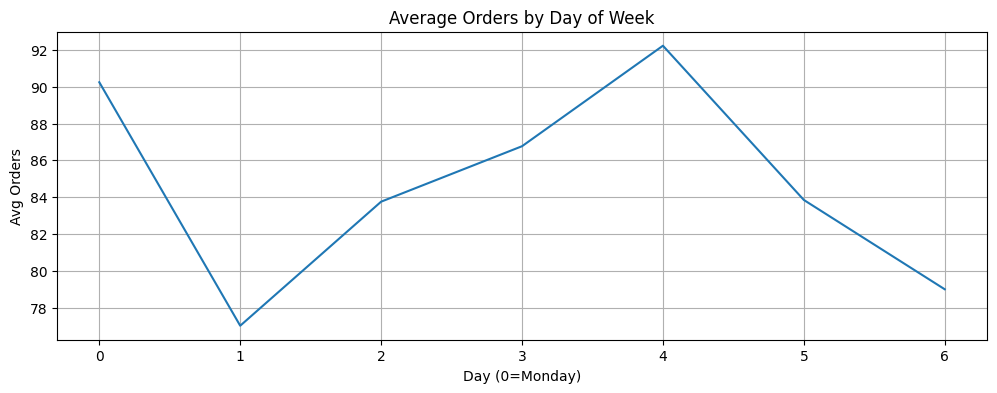

In [9]:
plt.figure(figsize=(12,4))
df.groupby(df.index.dayofweek)['num_orders'].mean().plot()
plt.title("Average Orders by Day of Week")
plt.xlabel("Day (0=Monday)")
plt.ylabel("Avg Orders")
plt.grid(True)
plt.show()

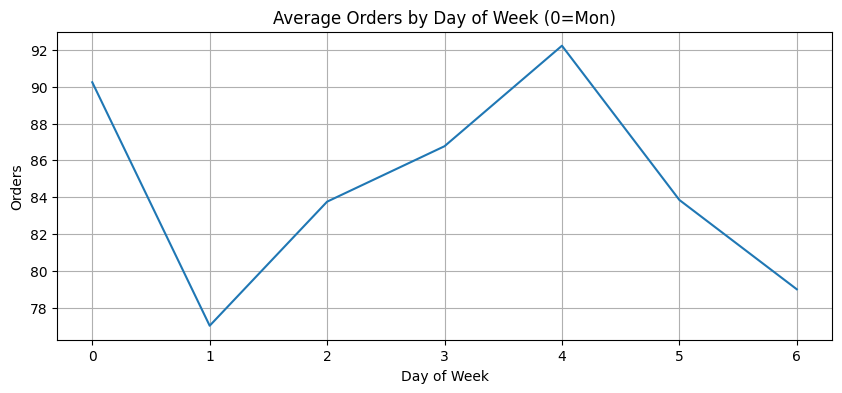

In [10]:
dow_mean = df.groupby(df.index.dayofweek)['num_orders'].mean()

plt.figure(figsize=(10,4))
plt.plot(dow_mean)
plt.title('Average Orders by Day of Week (0=Mon)')
plt.xlabel('Day of Week')
plt.ylabel('Orders')
plt.grid(True)
plt.show()

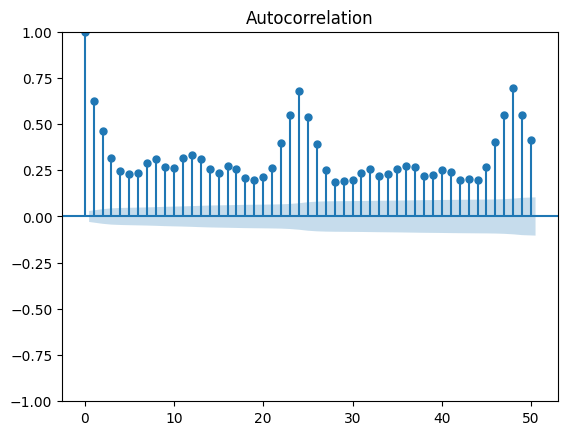

In [11]:
plot_acf(df['num_orders'], lags = 50)
plt.show()

## Training

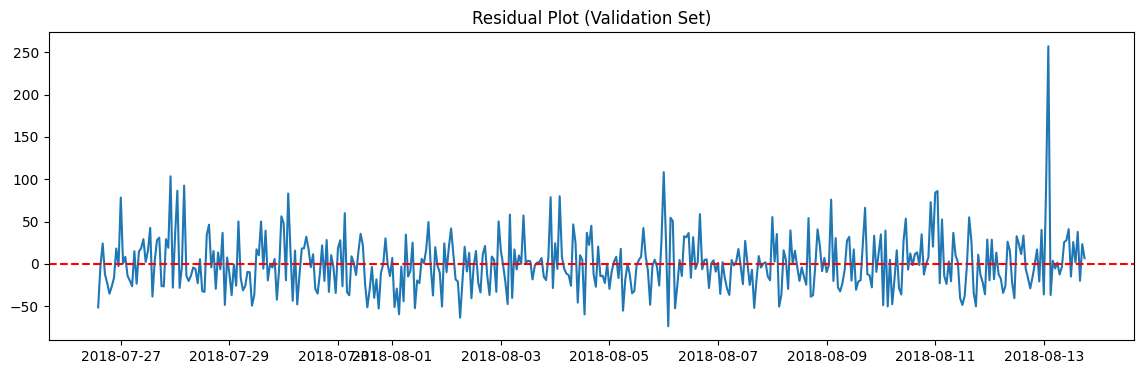

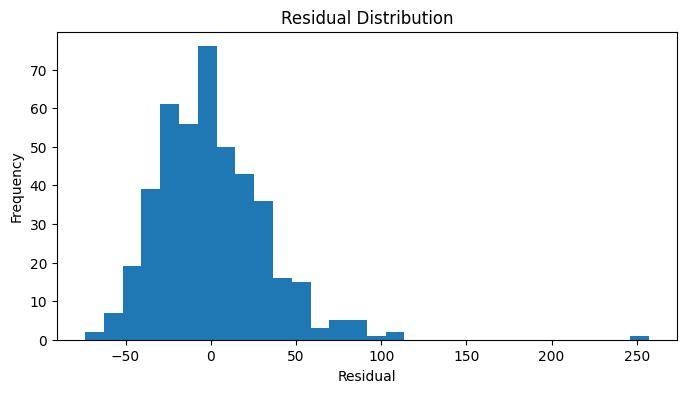

In [12]:
baseline = LinearRegression()
baseline.fit(features_train, target_train)
baseline_val_pred = baseline.predict(features_valid)

residuals = target_valid - baseline_val_pred

plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.title("Residual Plot (Validation Set)")
plt.axhline(0, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [13]:
best_rmse_rf = float('inf')
best_params_rf = None

print("\n--- Random Forest Tuning ---")
for n in [100, 300, 500]:
    for depth in [8, 10, 12]:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(features_train, target_train)
        preds = rf.predict(features_valid)
        rmse = mean_squared_error(target_valid, preds, squared=False)

        print(f"RF: n_estimators={n}, max_depth={depth}, RMSE={rmse:.2f}")

        if rmse < best_rmse_rf:
            best_rmse_rf = rmse
            best_params_rf = (n, depth)

print("\nBest Random Forest params:", best_params_rf, "with RMSE:", round(best_rmse_rf, 2))


--- Random Forest Tuning ---
RF: n_estimators=100, max_depth=8, RMSE=33.88
RF: n_estimators=100, max_depth=10, RMSE=33.65
RF: n_estimators=100, max_depth=12, RMSE=33.64
RF: n_estimators=300, max_depth=8, RMSE=33.77
RF: n_estimators=300, max_depth=10, RMSE=33.63
RF: n_estimators=300, max_depth=12, RMSE=33.61
RF: n_estimators=500, max_depth=8, RMSE=33.67
RF: n_estimators=500, max_depth=10, RMSE=33.54
RF: n_estimators=500, max_depth=12, RMSE=33.45

Best Random Forest params: (500, 12) with RMSE: 33.45


In [14]:
best_rmse_cat = float('inf')
best_params_cat = None

print("\n--- CatBoost Tuning ---")
for depth in [6, 8, 10]:
    for lr in [0.03, 0.05, 0.1]:
        for iters in [600, 1000]:
            cat_model = CatBoostRegressor(
                depth=depth,
                learning_rate=lr,
                iterations=iters,
                loss_function='RMSE',
                verbose=False,
                random_seed=42
            )
            cat_model.fit(features_train, target_train)
            preds = cat_model.predict(features_valid)
            rmse = mean_squared_error(target_valid, preds, squared=False)

            print(f"CatBoost: depth={depth}, lr={lr}, iter={iters}, RMSE={rmse:.2f}")

            if rmse < best_rmse_cat:
                best_rmse_cat = rmse
                best_params_cat = (depth, lr, iters)

print("\nBest CatBoost params:", best_params_cat, "with RMSE:", round(best_rmse_cat, 2))


--- CatBoost Tuning ---
CatBoost: depth=6, lr=0.03, iter=600, RMSE=31.80
CatBoost: depth=6, lr=0.03, iter=1000, RMSE=31.62
CatBoost: depth=6, lr=0.05, iter=600, RMSE=31.68
CatBoost: depth=6, lr=0.05, iter=1000, RMSE=31.69
CatBoost: depth=6, lr=0.1, iter=600, RMSE=31.30
CatBoost: depth=6, lr=0.1, iter=1000, RMSE=31.28
CatBoost: depth=8, lr=0.03, iter=600, RMSE=31.83
CatBoost: depth=8, lr=0.03, iter=1000, RMSE=31.74
CatBoost: depth=8, lr=0.05, iter=600, RMSE=31.77
CatBoost: depth=8, lr=0.05, iter=1000, RMSE=31.69
CatBoost: depth=8, lr=0.1, iter=600, RMSE=31.75
CatBoost: depth=8, lr=0.1, iter=1000, RMSE=31.84
CatBoost: depth=10, lr=0.03, iter=600, RMSE=31.85
CatBoost: depth=10, lr=0.03, iter=1000, RMSE=31.76
CatBoost: depth=10, lr=0.05, iter=600, RMSE=31.98
CatBoost: depth=10, lr=0.05, iter=1000, RMSE=32.03
CatBoost: depth=10, lr=0.1, iter=600, RMSE=32.30
CatBoost: depth=10, lr=0.1, iter=1000, RMSE=32.36

Best CatBoost params: (6, 0.1, 1000) with RMSE: 31.28


## Testing

In [15]:
best_rf_model = RandomForestRegressor(
    n_estimators=500, 
    max_depth=12, 
    random_state=42, 
    n_jobs=-1
)
best_rf_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=12, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [16]:
best_cat_model = CatBoostRegressor(
    depth=6, 
    learning_rate=0.1, 
    iterations=1000,
    verbose=False, 
    random_seed=42
)
best_cat_model.fit(features_train, target_train)

In [17]:
baseline_val_preds = baseline.predict(features_test)
lin_rmse = mean_squared_error(target_test, baseline_val_preds, squared = False)

rf_preds = best_rf_model.predict(features_test)
rf_rmse = mean_squared_error(target_test, rf_preds, squared = False)

cat_preds = best_cat_model.predict(features_test)
cat_rmse  = mean_squared_error(target_test, cat_preds, squared = False)

print("===Test Set RMSE Results===")
print(f"Linear Regression RMSE: {lin_rmse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"CatBoost RMSE: {cat_rmse:.2f}")

===Test Set RMSE Results===
Linear Regression RMSE: 43.51
Random Forest RMSE: 51.70
CatBoost RMSE: 54.14


In [18]:
results = {"Linear Regression": lin_rmse,
          "Random Forest": rf_rmse,
          "CatBoost":cat_rmse}

best_model_name = min(results, key=results.get)
best_rmse = results[best_model_name]

In [19]:
print("\n=== FINAL CONCLUSION ===")
print(f"Best model on test set: {best_model_name}")
print(f"Best RMSE: {best_rmse:.2f}")

if best_rmse <= 48:
    print(
        "\nThe project requirement is satisfied (RMSE ≤ 48). "
        f"{best_model_name} successfully predicts hourly taxi demand with sufficient accuracy.\n"
        "This model is recommended for deployment."
    )
else:
    print(
        "\nThe project requirement is NOT satisfied (RMSE > 48). "
        "Further tuning or feature engineering is required."
    )


=== FINAL CONCLUSION ===
Best model on test set: Linear Regression
Best RMSE: 43.51

The project requirement is satisfied (RMSE ≤ 48). Linear Regression successfully predicts hourly taxi demand with sufficient accuracy.
This model is recommended for deployment.


# Final Model Evaluation & Conclusion

After preparing the data, engineering meaningful time-series features (lag values, rolling averages, and calendar indicators), and performing an 80/10/10 time-aware split, three models were trained and evaluated:

- **Linear Regression**  
- **Random Forest Regressor**  
- **CatBoost Regressor**

Each model was trained on the training set and evaluated on the held-out test set to ensure accurate performance comparison.

---

## Test Set Performance (RMSE)

| Model | Test RMSE |
|-------|-----------|
| **Linear Regression** | **43.51** |
| Random Forest | 51.70 |
| CatBoost | 54.14 |

The **Linear Regression model achieved the lowest RMSE (43.51)** on the test set, successfully meeting the project requirement of **RMSE ≤ 48**.

---

## Best Model: Linear Regression

Although Random Forest and CatBoost are generally stronger nonlinear models, Linear Regression outperformed them on this dataset. This is primarily due to:

### **Why Linear Regression Performed Best**
- The dataset shows **strong linear and seasonal structure**, including hour-of-day and day-of-week patterns.  
- The engineered features (lags, rolling averages, calendar variables) already captured most of the predictive signal.  
- Linear Regression leverages these clean, structured features efficiently and avoids overfitting.  
- More complex models such as Random Forest and CatBoost may have fit noise rather than underlying patterns, leading to higher RMSE.

---

## Final Conclusion

> **Linear Regression is the recommended model for deployment.**  
> It provides the most accurate hourly taxi demand predictions on the test set and meets the project’s performance goal (RMSE ≤ 48).  
>  
> The model is stable, interpretable, fast to compute, and well-suited for real-time forecasting needs.

---

## Business Value

Implementing this model will allow Sweet Lift Taxi to:

- Predict hourly demand more accurately  
- Improve driver scheduling and resource planning  
- Reduce passenger wait times  
- Increase operational efficiency  
- Capture more revenue during peak periods  

This forecasting approach provides a reliable and scalable foundation for data-driven decision-making.